# Training GCN AE on Full Data

In [28]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

### Time Series Sequencing

In [2]:
def sequence_gcnae(data, timesteps, hide_anomalies=True):
    sequence = []
    static_edges = generate_edges(milemarkers=list(range(49)))
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times)):
        data_t = []
        contains_anomaly = np.any([np.unique(data[data['unix_time']==t]['anomaly'])[0]])

        if (hide_anomalies and contains_anomaly):
            continue
        
        kept_indices.append(index)

        data_t.append(data[data['unix_time']==t][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not
        
        curr_data = data_t[-1]
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append(curr_graph)

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
optimal_hyperparams = load_best_parameters('gcn_v2')

optimal_hyperparams

{'learning_rate': 0.0004708326073117493,
 'timesteps': 2,
 'epochs': 10,
 'latent_dim': 128,
 'gcn_hidden_dim': 64,
 'dropout': 0.03472588957921531,
 'num_gcn': 1}

In [4]:
mse_weights = [0.2, 0.6, 0.2] # weights for loss function (occupancy, speed, volume)

In [5]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'] * 2,
    timesteps=0,
    batch_size=1,
    n_epochs=5
)

In [6]:
import os

train_path, test_path = '../data/train_data.csv', '../data/test_data.csv'

if os.path.exists(train_path) and os.path.exists(test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
else:
    train_data, test_data, _ = get_full_data()
    train_data = normalize_data(train_data)
    train_data = label_anomalies(train_data)

    train_data.to_csv(train_path)
    test_data.to_csv(test_path)

train_sequence, kept_train_indices = sequence_gcnae(train_data, training_params.timesteps)

100%|██████████| 13440/13440 [01:14<00:00, 180.93it/s]


In [7]:
hyperparams = GraphAEParameters(
    num_features=3,
    latent_dim=64,
    gcn_hidden_dim=64,
    dropout=0.3,
    num_gcn=6
)

In [8]:
ae = GraphAE(hyperparams)

In [9]:
ae(train_sequence[0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [10]:
using_pretrained = False

if not using_pretrained:
    ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, 'gcn')
else:
    ae = load_model(GraphAE, hyperparams, 'gcn')

 20%|██        | 1/5 [01:34<06:19, 94.86s/it]

Epoch number 1 loss: 0.012434607589360665


 40%|████      | 2/5 [03:08<04:42, 94.02s/it]

Epoch number 2 loss: 0.0054003582410441274


 60%|██████    | 3/5 [04:53<03:18, 99.29s/it]

Epoch number 3 loss: 0.005206743637713412


 80%|████████  | 4/5 [06:23<01:35, 95.67s/it]

Epoch number 4 loss: 0.005149145854160295


100%|██████████| 5/5 [08:11<00:00, 98.40s/it] 

Epoch number 5 loss: 0.004852908017017431


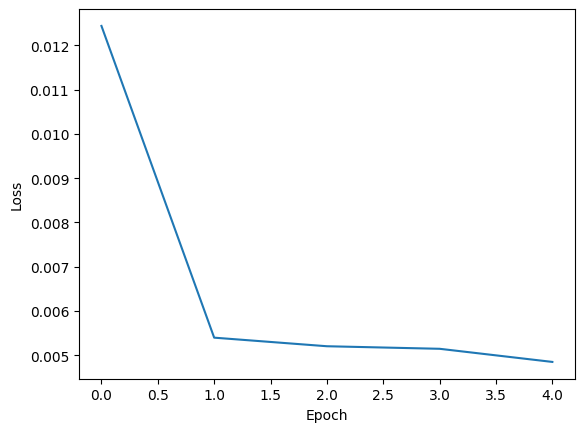

In [11]:
if not using_pretrained:
    plt.plot(losses)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

### Computing Node-level Anomaly Threshold

In [12]:
thresh = compute_anomaly_threshold_gcnae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 6436/6436 [01:00<00:00, 106.77it/s]


### Loading Test Data

In [13]:
_, df_test_data, _ = get_full_data()

In [14]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4800/4800 [00:21<00:00, 225.83it/s]


In [15]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [16]:
np.mean(test_errors)

np.float32(0.006880261)

In [17]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

### Compute FPR / Crash Detection Delay Tradeoff

In [18]:
thresh.shape

(196,)

In [19]:
test_errors.shape

(4800, 196)

In [20]:
anomaly_labels.shape

(940800,)

In [21]:
crash_reported.shape

(4800,)

In [30]:
def find_delays(thresh, errors, anomaly_labels, crash_reported, changed_sr=False, sr=0.5):
    results = []
    thresholds = np.array(find_thresholds(thresh, errors, anomaly_labels, changed_sr))
    all_fp_indices = np.where(thresholds[:,0] == 1)[0]
    all_fp_index = all_fp_indices[-1] if len(all_fp_indices) > 0 else None

    no_fp_indices = np.where(thresholds[:,0] == 0)[0]
    no_fp_index = no_fp_indices[-1] if len(no_fp_indices) > 0 else None
    val_range = np.linspace(0.01, 0.99, 98)

    if no_fp_index is None:
        # do something here
        pass
    
    anomaly_pred = threshold_anomalies(thresh + thresholds[no_fp_index][1], errors)
    delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
    results.append([0, np.mean(delays), np.std(delays), np.sum(detects)/12])

    for i in tqdm(val_range):
        # offset_index = np.abs(thresholds[:,0] - i).argmin()
        offset_index = thresholds.shape[0] - 1 - np.argmin(np.abs(thresholds[:,0][::-1] - i))
        offset = thresholds[offset_index,1]
        anomaly_pred = threshold_anomalies(thresh+offset, errors)
        delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
        if np.sum(detects) == 0:
            delays = [15/sr]
        results.append([thresholds[offset_index,0], np.mean(delays), np.std(delays), np.sum(detects)/12])
        
    anomaly_pred = threshold_anomalies(thresh+thresholds[all_fp_index][1], errors)
    delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
    results.append([1, np.mean(delays), np.std(delays), np.sum(detects)/12])

    return results

In [31]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encounter

In [32]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/gcnae_fp_delay.csv')

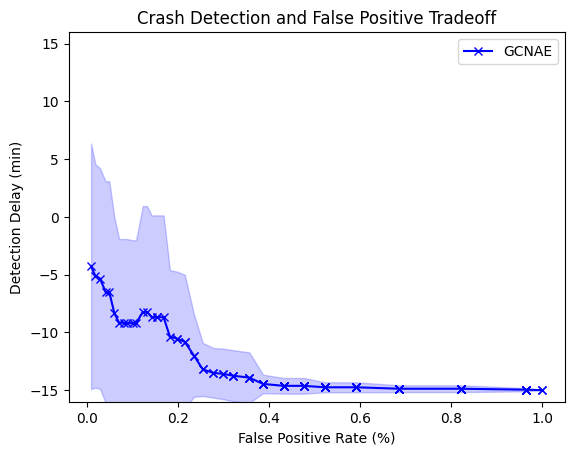

In [33]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [34]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [01:45<00:00,  9.46it/s]

Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02449979583503471 for 0.025
Found FPR of 0.04981625153123724 for 0.05
Found FPR of 0.10208248264597795 for 0.1
Found FPR of 0.19885667619436503 for 0.2
FPR 1% gives mean delay of -4.277777777777778 +/- 10.630436154716614 while missing 0.25%.
FPR 2.5% gives mean delay of -5.222222222222222 +/- 9.609344731709832 while missing 0.25%.
FPR 5% gives mean delay of -6.5 +/- 9.588766575761683 while missing 0.25%.
FPR 10% gives mean delay of -9.222222222222221 +/- 7.203822716335756 while missing 0.25%.
FPR 20% gives mean delay of -10.545454545454545 +/- 5.81320810136297 while missing 0.08333333333333337%.


### Compute AUC

In [35]:
calculate_auc(test_errors, anomaly_labels)

0.7118791242583267

### Copmute Detection Delay Histogram on Full Dataset

In [36]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [37]:
full_sequence, kept_full_indices = sequence_gcnae(full_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 18240/18240 [02:46<00:00, 109.39it/s]


In [38]:
full_errors, _, _ = test_gcnae(full_sequence, mse_weights, ae)

In [39]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

In [40]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


In [41]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)

Found FPR of 0.09613604812586765 for 0.1


In [42]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

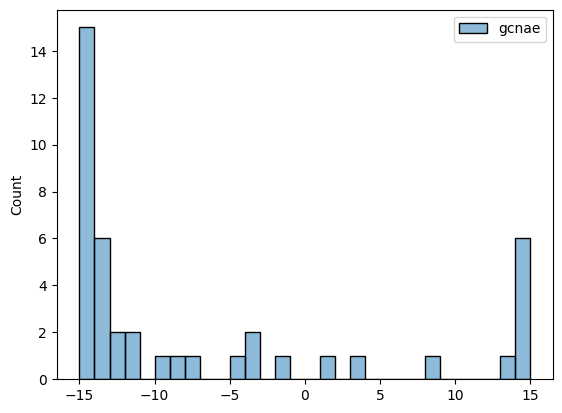

In [43]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='gcnae')
plt.legend()

In [44]:
np.save('./saved_results/gcnae10delays.npy', np.array(delay)/2)

In [45]:
_, df_clean_test_data, _ = get_full_data()

In [46]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gcnae(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4800/4800 [00:09<00:00, 512.79it/s]


In [47]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_gcnae(clean_test_data, mse_weights, ae)

In [48]:
np.mean(clean_test_errors)

np.float32(0.0056594666)

In [ ]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [ ]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()